# EWE8044 

## Homework #1 and #2 Entropy of Colors

*2019170229 Bae Jiun*

*<small>Updated 2019/10/21</small>*

### Objective

1. Entropy Analysis of Each Color Component
    - RGB: $H(R), H(G), H(B)$
    - YUV: $H(Y), H(U), H(V)$
    - Lab-1976: $H(L), H(a), H(b)$
    
2. Conditional Entropy and Correlation Coefficient Analysis of Y and RGB Components
    - $H(Y|R), H(Y|G), H(Y|B)$
    - $\rho YR, \rho YG, \rho YB$

3. Image processing case collection considering the entropy characteristics of color components
    - Image compression using YUV component
    - color filter array (Bayer filter)

## Requirements

- Imageset [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data)
- Python 3.6 (or above)
    - [numpy](https://pypi.org/project/numpy/)
    - [skimage](https://pypi.org/project/scikit-image/)
    - [pillow](https://pypi.org/project/Pillow/)
    - [sklearn](https://pypi.org/project/scikit-learn/)

## Prepare Image set

[Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) is [Kaggle](https://www.kaggle.com/) competition.

In this competition, We can use dataset for write an algorithm to classify whether images contain either a dog or a cat.

Load the image using opencv.

In [1]:
from pathlib import Path

import numpy as np
from skimage import io, color, transform
from PIL import Image

In [2]:
category = {'cat', 'dog'}
images = {c: list(map(io.imread, sorted(Path('train').glob(f'{c}*')))) for c in category}

## Thumbnail

Let's see what the images in the dataset will look like.

In [3]:
from itertools import product
from random import choice

from IPython.display import display

From the left 8x8 image, each are cat, dog


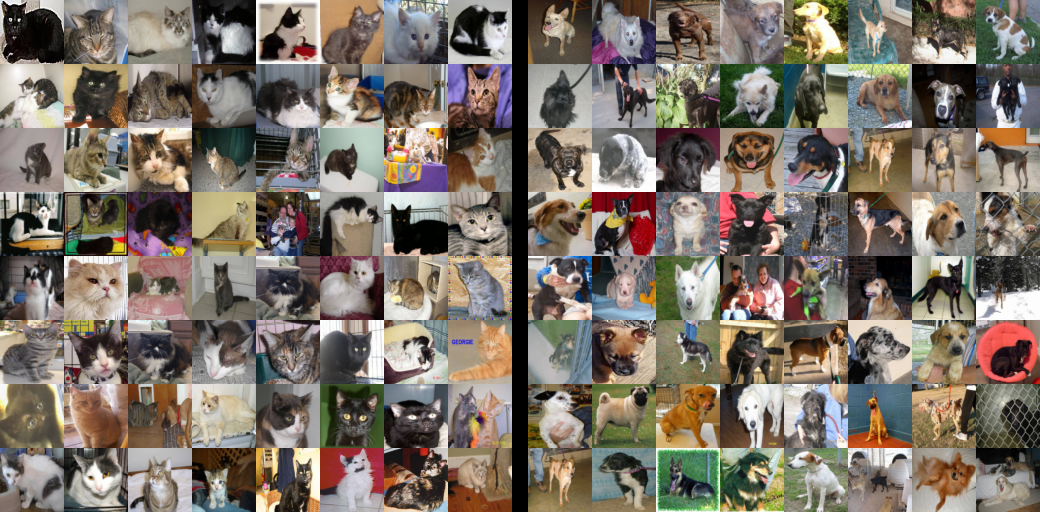

In [4]:
w, h, n, pad = 64, 64, 8, 16
showcase = np.zeros((h * n, w * n * len(category) + pad * (len(category) - 1), 3), dtype=np.uint8)

print(f'From the left {n}x{n} image, each are {", ".join(images)}')
for i, imgs in enumerate(images.values()):
    for x, y in product(range(n), range(n)):
        showcase[y*h:(y+1)*h, (n*w+pad)*i+x*w:(n*w+pad)*i+(x+1)*w] = (transform.resize(choice(imgs), (w, h)) * 255).astype(np.uint8)
display(Image.fromarray(showcase))

In [5]:
image = choice(images[choice(tuple(category))])

# Entropy of each channel

It is possible to calculate the entropy $H(x)$ using the following equation:

$$H(x) = - \sum^n_{i=1} p_i log_2 p_i$$

The $p_i$ value is the occurrence probability of a given symbol. Here, the symbols are the pixels. To simplify it, let’s consider a single-channel 8-bit image (256 intensity levels), then we can compute $p_i$ value as follows:

$$p_i = \frac {Number \ of \ occurrences \ of \ the \ intensity \ level \ i} {Number \ of \ intensity \ pixels}$$ 

In [6]:
def entropy(image):
    histogram = np.histogramdd(np.ravel(image), bins=256)[0] / image.size
    histogram = histogram[histogram > 0]
    return -np.sum(np.multiply(histogram, np.log2(histogram)))

First column represents each R, G, B channels
Entropy of each channel H(R): 7.5203, H(G): 7.5681, H(B): 7.5278.
Second column represents each Y, U, V channels
Entropy of each channel H(Y): 7.6070, H(U): 7.0506, H(V): 5.8735.
Third column represents each Y, a, b channels
Entropy of each channel H(L): 7.5718, H(a): 5.4995, H(b): 7.0981.


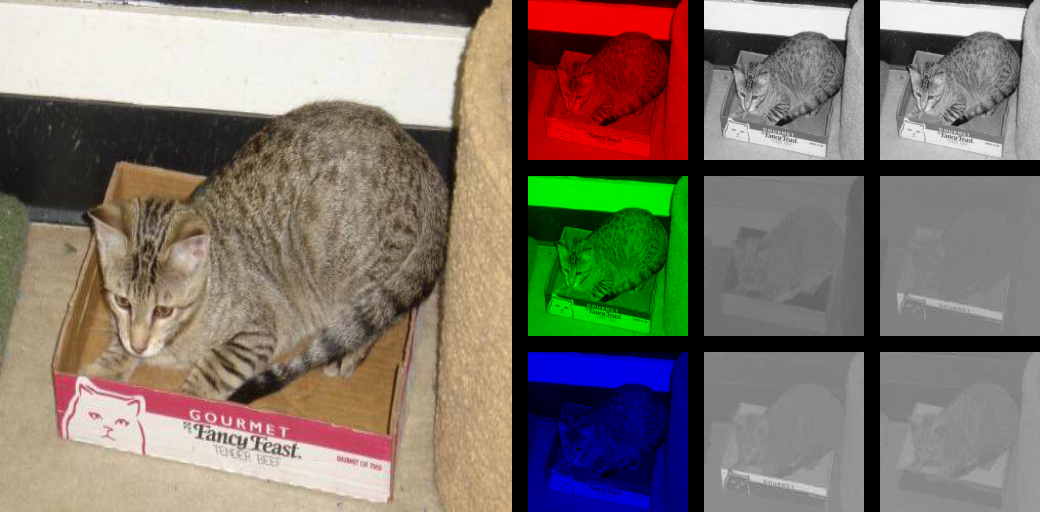

In [7]:
w, h, pad = 512, 512, 16
sw, sh = int((w - pad * 2) / 3), int((h - pad * 2) / 3)

showcase = np.zeros((h, int(w + (pad + sw) * 3), 3), dtype=np.uint8)
showcase[:h, :w] = (transform.resize(image, (w, h)) * 255).astype(np.uint8)

# RGB entropy
entropies = []
r, g, b = image.transpose(2, 0, 1)
for j, channel in enumerate([r, g, b]):
    entropies.append(entropy(channel))
    showcase[(sh+pad)*j:(sh+pad)*j+sh, w+pad:w+pad+sw, j] = (transform.resize(channel, (sw, sh)) * 255).astype(np.uint8)
print('First column represents each R, G, B channels')
print(f'Entropy of each channel {", ".join([f"H({label}): {value:.4f}" for value, label in zip([round(e, 4) for e in entropies], "RGB")])}.')

# YUV entropy
entropies = []
y, u, v = color.rgb2yuv(image).transpose(2, 0, 1)
for j, (channel, offset) in enumerate(zip([y, u, v], [0, .5, .5])):
    temp = (transform.resize(channel, (sw, sh)) + offset) * 255
    entropies.append(entropy(temp))
    showcase[(sh+pad)*j:(sh+pad)*j+sh, w+pad+sw+pad:w+pad+sw+pad+sw] = np.stack((temp, temp, temp)).transpose(1, 2, 0)
print('Second column represents each Y, U, V channels')
print(f'Entropy of each channel {", ".join([f"H({label}): {value:.4f}" for value, label in zip([round(e, 4) for e in entropies], "YUV")])}.')

# Lab entropy    
entropies = []
L, a, b = color.rgb2lab(image).transpose(2, 0, 1)
for j, (channel, offset, ratio) in enumerate(zip([L, a, b], [0, 128., 128.], [2.55, 1, 1])):
    temp = (transform.resize(channel, (sw, sh)) + offset) * ratio
    entropies.append(entropy(temp))
    showcase[(sh+pad)*j:(sh+pad)*j+sh, w+pad+(sw+pad)*2:w+pad+(sw+pad)*2+sw] = np.stack((temp, temp, temp)).transpose(1, 2, 0)
print('Third column represents each Y, a, b channels')
print(f'Entropy of each channel {", ".join([f"H({label}): {value:.4f}" for value, label in zip([round(e, 4) for e in entropies], "Lab")])}.')
    
display(Image.fromarray(showcase))

## Local Entropy analysis

For an image, local entropy is related to the complexity contained in a given neighborhood, typically defined by a structuring element. The entropy filter can detect subtle variations in the local gray level distribution.

Below images show each channel local entropy

In [8]:
from skimage.filters import rank
from skimage.morphology import disk

/home/jiun/conda/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


First column represents each R, G, B local entropy
Second column represents each Y, U, V local entropy
Third column represents each L, a, b local entrop


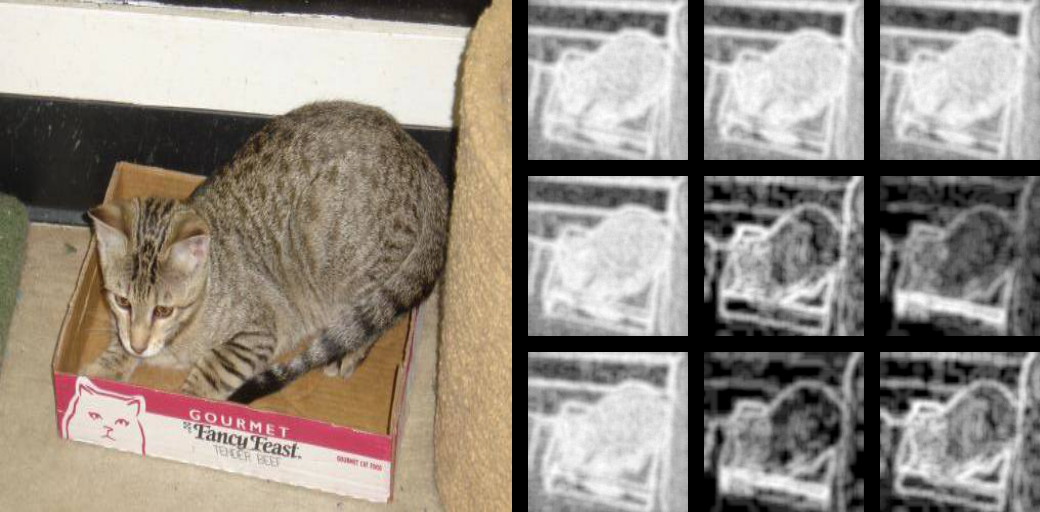

In [9]:
w, h, pad, d = 512, 512, 16, 5
sw, sh = int((w - pad * 2) / 3), int((h - pad * 2) / 3)

showcase = np.zeros((h, int(w + (pad + sw) * 3), 3), dtype=np.uint8)
showcase[:h, :w] = (transform.resize(image, (w, h)) * 255).astype(np.uint8)

# RGB local entropy
r, g, b = image.transpose(2, 0, 1)
for j, channel in enumerate([r, g, b]):
    temp = rank.entropy(transform.resize(channel, (sw, sh)), disk(d))
    showcase[(sh+pad)*j:(sh+pad)*j+sh, w+pad:w+pad+sw] = np.stack((temp, temp, temp)).transpose(1, 2, 0) * (255 / temp.max())
print('First column represents each R, G, B local entropy')

# YUV local entropy
y, u, v = color.rgb2yuv(image).transpose(2, 0, 1)
for j, (channel, offset) in enumerate(zip([y, u, v], [0, .5, .5])):
    temp = rank.entropy(((transform.resize(channel, (sw, sh)) + offset) * 255).astype(np.uint8), disk(d))
    showcase[(sh+pad)*j:(sh+pad)*j+sh, w+pad+sw+pad:w+pad+sw+pad+sw] = np.stack((temp, temp, temp)).transpose(1, 2, 0) * (255 / temp.max())
print('Second column represents each Y, U, V local entropy')

# Lab local entropy
L, a, b = color.rgb2lab(image).transpose(2, 0, 1)
for j, (channel, offset, ratio) in enumerate(zip([L, a, b], [0, 128., 128.], [2.55, 1, 1])):
    temp = rank.entropy(((transform.resize(channel, (sw, sh)) + offset) * ratio).astype(np.uint8), disk(d))
    showcase[(sh+pad)*j:(sh+pad)*j+sh, w+pad+(sw+pad)*2:w+pad+(sw+pad)*2+sw] = np.stack((temp, temp, temp)).transpose(1, 2, 0) * (255 / temp.max())
print('Third column represents each L, a, b local entrop')

display(Image.fromarray(showcase))

# Conditional Entropy $H(Y|X)$

It is possible to calculate the conditional entropy $H(Y|X)$ using the following equation:

$$H(Y|X) = - \sum_{x \in X, y \in Y} p(x, y) log \frac {p(x, y)} {p(x)}$$

also same as:

$$\begin{align} \begin{split} H(X|Y) &= E[-log_b P(X|Y)] \\ &= \sum_yP(y) H(X|Y=y) \\&= \sum_yP(y) \sum_xP(x|y)log \frac{1}{P(x|y)} \\&= \sum_y \sum_x P(y) P(x|y) log \frac{1}{P(x|y)} \\&= \sum_x \sum_y P(x, y) log_b \frac {1} {P(x|y)} \end{split} \end{align}$$


In [10]:
def cond_entropy(x, y):
    return sum(((x == e).sum() / x.size) * entropy(y[(x == e)]) for e in np.unique(x))

In [11]:
r, g, b = image.transpose(2, 0, 1)
y, u, v = color.rgb2yuv(image).transpose(2, 0, 1)

entropies = [cond_entropy(c, y) for c in [r, g, b]]
print(f'Conditional entropy of each channel: \n{", ".join([f"H(Y|{label}): {value:.4f}" for value, label in zip([round(e, 4) for e in entropies], "RGB")])}.')

Conditional entropy of each channel: 
H(Y|R): 4.5812, H(Y|G): 4.5869, H(Y|B): 4.7483.


# Correlation Coefficient $\rho_{XY}$

Pearson product-moment correlation coefficients define as following equation:
$$R_{ij} = \frac{C_{ij}} {\sqrt {{C_{ii}} * {C_{jj}}}}$$

or, also defined as:

$$E[(X-M_X)(Y-M_Y)] = E[\sigma_X \sigma_Y] =\rho_{XY} = \frac {E[XY] - M_X M_Y} {\sigma_X \sigma_Y}$$

First column represents each R, G, B channels
Second column represents each R, G, B local entropy
Third column represents each R, G, B correlation coefficient with Y
Correlation Coefficient of each channel: 
rho(RY): 4.5812, rho(GY): 4.5869, rho(BY): 4.7483.


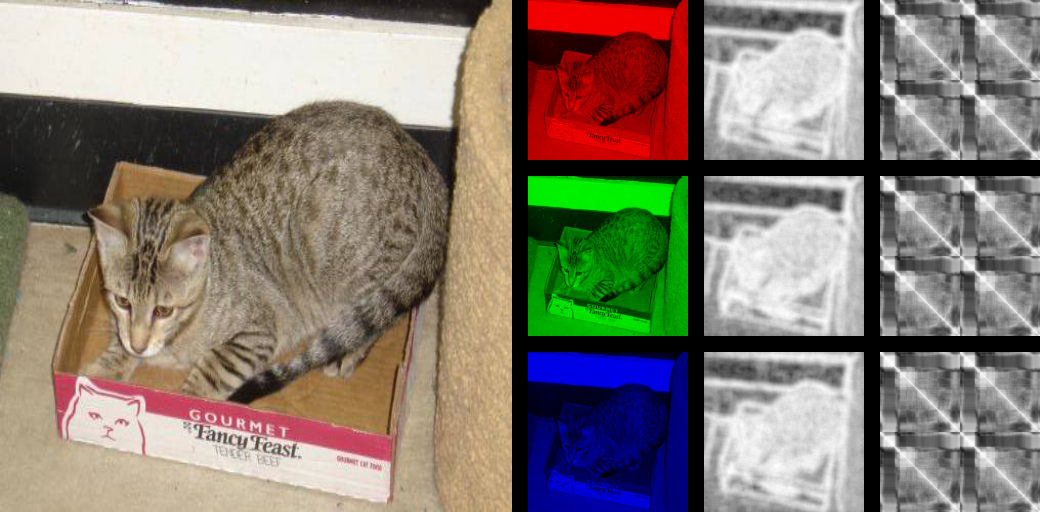

In [12]:
w, h, pad = 512, 512, 16
sw, sh = int((w - pad * 2) / 3), int((h - pad * 2) / 3)

showcase = np.zeros((h, int(w + (pad + sw)*3), 3), dtype=np.uint8)
showcase[:h, :w] = (transform.resize(image, (w, h)) * 255).astype(np.uint8)

# RGB entropy
r, g, b = image.transpose(2, 0, 1)
for j, channel in enumerate([r, g, b]):
    entropies.append(entropy(channel))
    showcase[(sh+pad)*j:(sh+pad)*j+sh, w+pad:w+pad+sw, j] = (transform.resize(channel, (sw, sh)) * 255).astype(np.uint8)
print('First column represents each R, G, B channels')

# RGB local entropy
for j, channel in enumerate([r, g, b]):
    temp = rank.entropy(transform.resize(channel, (sw, sh)), disk(d))
    showcase[(sh+pad)*j:(sh+pad)*j+sh, w+pad+sw+pad:w+pad+sw+pad+sw] = np.stack((temp, temp, temp)).transpose(1, 2, 0) * (255 / temp.max())
print('Second column represents each R, G, B local entropy')

# RGB correlation coefficient
corrcoef = []
for j, channel in enumerate([r, g, b]):
    temp = ((np.corrcoef(channel, y) + 1) * 127.5).astype(np.uint8)
    corrcoef.append(temp.mean())
    temp = (transform.resize(temp, (sw, sh)) * 255).astype(np.uint8)
    showcase[(sh+pad)*j:(sh+pad)*j+sh, w+pad+(sw+pad)*2:w+pad+(sw+pad)*2+sw] = np.stack((temp, temp, temp)).transpose(1, 2, 0)
print('Third column represents each R, G, B correlation coefficient with Y')

print(f'Correlation Coefficient of each channel: \n{", ".join([f"rho({label}Y): {value:.4f}" for value, label in zip([round(e, 4) for e in entropies], "RGB")])}.')
      
display(Image.fromarray(showcase))

# Chroma subsampling

Chroma subsampling is the practice of encoding images by implementing less resolution for chroma information than for luma information, taking advantage of the human visual system's lower acuity for color differences than for luminance.

It is used in many video encoding schemes – both analog and digital – and also in JPEG encoding.

So, We will convert the images to the $Y, U, V$ color space, change the scale of the $U, V$ compress them, and restore them to see how much they are lost.

After compress, calculate [PSNR: Peak signal-to-noise ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) to compare how much it matches the original image

PSNR is most easily defined via the mean sqaured error. Given a noise-free $m \times n$ monochrome image and its noisy approximation K, MSE is defined as follow:

$$MSE = \frac {1} {m n} \sum^{m-1}_{i=0} \sum^{n-1}_{j=0} [I(i, j) - K(i, j)]^2$$

The PSNR is defined as:

$$\begin{align} \begin{split} PSNR &= 10 \cdot log_{10} \left( \frac {MAX^2_I} {MSE} \right) \\ &= 20 \cdot \left(\frac {MAX_I} {\sqrt{MSE}}\right) \\ &= 20 \cdot log_{10} (MAX_I) - 10 \cdot log_{10} (MSE) \end{split} \end{align}$$

In [13]:
def psnr(source: np.ndarray, target: np.ndarray) -> float:
    mse = np.mean((source - target) ** 2)
    return 100 if mse == 0 else 20 * np.log10(255. / np.sqrt(mse))

In [14]:
def compress(source: np.ndarray, ratio: float = .5) -> np.ndarray:
    y, u, v = color.rgb2yuv(source).transpose(2, 0, 1)
    u = transform.resize(transform.resize(u, (int(u.shape[0] * ratio), int(u.shape[1] * ratio))), y.shape)
    v = transform.resize(transform.resize(v, (int(v.shape[0] * ratio), int(v.shape[1] * ratio))), y.shape)
    return color.yuv2rgb(np.stack((y, u, v)).transpose(1, 2, 0))

Original image size: 374 x 500 x 3 = 561000
Compressed image size: 374 x 500 + 187 x 250 x 2 = 187500
Copressed ratio: 0.33
PSNR: 4.16


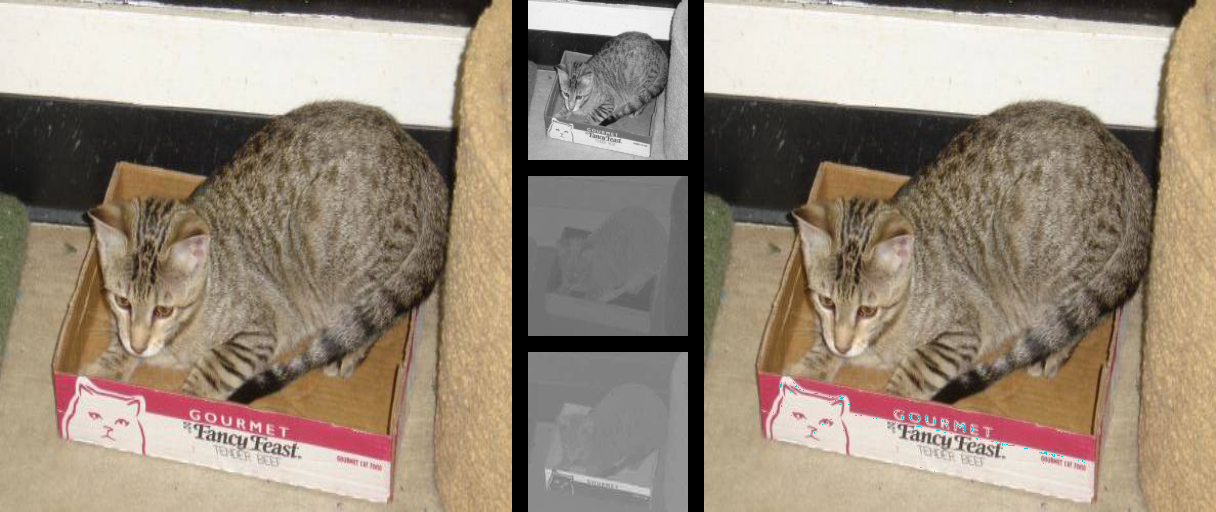

In [15]:
w, h, pad, ratio = 512, 512, 16, .5
sw, sh = int((w - pad * 2) / 3), int((h - pad * 2) / 3)

showcase = np.zeros((h, int(w * 2 + (pad + sw) + pad), 3), dtype=np.uint8)
showcase[:h, :w] = (transform.resize(image, (w, h)) * 255).astype(np.uint8)

y, u, v = color.rgb2yuv(image).transpose(2, 0, 1)
for j, (channel, offset) in enumerate(zip([y, u, v], [0, .5, .5])):
    temp = (transform.resize(channel, (sw, sh)) + offset) * 255
    showcase[(sh+pad)*j:(sh+pad)*j+sh, w+pad:w+pad+sw] = np.stack((temp, temp, temp)).transpose(1, 2, 0)
    
revert = compress(image, ratio)
showcase[:h, w+pad+sw+pad:] = (transform.resize(revert, (w, h)) * 255).astype(np.uint8)

print(f'Original image size: {image.shape[0]} x {image.shape[1]} x {image.shape[2]} = {image.size}')
print(f'Compressed image size: {image.shape[0]} x {image.shape[1]} + {int(image.shape[0] * ratio)} x {int(image.shape[1] * ratio)} x {2} = {y.size + int(image.shape[1] * ratio) * 2}')
print(f'Copressed ratio: {(y.size + int(image.shape[1] * ratio) * 2) / image.size:.2f}')
print(f'PSNR: {psnr(image, revert):.2f}')

display(Image.fromarray(showcase))

# Conditional Entropy of $H(RGB|Y)$

From above, we calculate $H(Y|RGB)$.

In this section we calculate $H(RGB|Y)$ of 32 images to see trends.

In [16]:
entropies = np.empty((0, 6))
for _ in range(32):
    image = choice(images[choice(tuple(category))])
    
    r, g, b = image.transpose(2, 0, 1)
    y, u, v = color.rgb2yuv(image).transpose(2, 0, 1)

    entropies = np.concatenate((
        entropies,
        np.expand_dims(np.array([
            *[cond_entropy(c, y) for c in [r, g, b]], 
            *[cond_entropy((y * 255).astype(np.uint8), c) for c in [r, g, b]]
        ]), 0),
    )) 

In [17]:
means = entropies.mean(axis=0)
print('Conditional entropy of each channel:')
print(f'{", ".join([f"H(Y|{label}): {value:.4f}" for value, label in zip([round(e, 4) for e in means[:3]], "RGB")])}.')
print(f'{", ".join([f"H({label}|Y): {value:.4f}" for value, label in zip([round(e, 4) for e in means[3:]], "RGB")])}.')

Conditional entropy of each channel:
H(Y|R): 4.8648, H(Y|G): 5.1735, H(Y|B): 4.7695.
H(R|Y): 3.9150, H(G|Y): 2.9964, H(B|Y): 4.2494.


We can check the difference of conditional entropy between $H(RGB|Y)$ and $H(Y|RGB)$

The value of $H(Y|G)$ is higher than other $H(Y|RGB)$, but $H(G|Y)$ is lower than other $H(G|Y)$.

By dividing each value, you can clearly see the correlation with each value.

In [18]:
print(', '.join([f"H({c}|Y)/H(Y|{c}): {v:.4f}" for v, c in zip(means[3:] / means[:3], "RGB")]))

H(R|Y)/H(Y|R): 0.8048, H(G|Y)/H(Y|G): 0.5792, H(B|Y)/H(Y|B): 0.8909


# Anaylsis: The difference between the two classes

Use 2500 images in each of the dog and cat classes.

In [19]:
from functools import partial

In [20]:
def operation(image: np.ndarray):
    r, g, b = image.transpose(2, 0, 1)
    y, u, v = color.rgb2yuv(image).transpose(2, 0, 1)
    return np.nan_to_num(np.array((
        *list(map(entropy, [r, g, b])),
        *list(map(partial(cond_entropy, y=y), [r, g, b])),
        *list(map(partial(cond_entropy, (y*255).astype(np.uint8)), [r, g, b])),
        np.corrcoef(r, y).mean(), np.corrcoef(g, y).mean(), np.corrcoef(b, y).mean(),
        psnr(image, compress(image, ratio)),
    )))

In [21]:
entropies = {category: np.array(tuple(map(operation, imgs[:32]))) for category, imgs in images.items()}

In [22]:
for c, e in entropies.items():
    print(f'Class: {c}')
    print(f'RGB entropy: \t\t\t{e[:, 0].mean():.4f}, {e[:, 1].mean():.4f}, {e[:, 2].mean():.4f}')
    print(f'Conditional entropy (RGB|Y): \t{e[:, 3].mean():.4f}, {e[:, 4].mean():.4f}, {e[:, 5].mean():.4f}')
    print(f'Conditional entropy (Y|RGB): \t{e[:, 6].mean():.4f}, {e[:, 7].mean():.4f}, {e[:, 8].mean():.4f}')
    print(f'Correlation coefficient: \t{e[:, 9].mean():.4f}, {e[:, 10].mean():.4f}, {e[:, 11].mean():.4f}')
    print(f'PSNR mean: {e[:, 12].mean():.4f}, std: {e[:, 12].std():.4f}')

Class: cat
RGB entropy: 			7.3791, 7.3754, 7.3304
Conditional entropy (RGB|Y): 	4.7288, 5.0007, 4.6675
Conditional entropy (Y|RGB): 	3.8147, 2.7460, 4.2156
Correlation coefficient: 	0.2553, 0.2644, 0.2624
PSNR mean: 6.5561, std: 1.9291
Class: dog
RGB entropy: 			7.4807, 7.3695, 7.3397
Conditional entropy (RGB|Y): 	5.0755, 5.4216, 4.9968
Conditional entropy (Y|RGB): 	4.2808, 3.2794, 4.5827
Correlation coefficient: 	0.2741, 0.2653, 0.2686
PSNR mean: 6.0350, std: 1.2462


# Prediction error and conditional entropy analysis

In this section, split train, test set and training linear prediction model and calculate expected squared error and reverse expected prediction squared errors.

In [23]:
from itertools import chain

In [24]:
train_data = chain(*[imgs[:100] for imgs in images.values()])
test_data = chain(*[imgs[100:150] for imgs in images.values()])

In [25]:
train_channel = [np.empty((0, 2)) for _ in range(3)]
test_channel = [np.empty((0, 2)) for _ in range(3)]
train_cond_entropy = [[] for _ in range(3)]
test_cond_entropy = [[] for _ in range(3)]

for image in train_data:
    r, g, b = image.transpose(2, 0, 1)
    y, u, v = color.rgb2yuv(image).transpose(2, 0, 1)
    
    for i, c in enumerate([r, g, b]):
        train_channel[i] = np.concatenate((
            train_channel[i],
            np.array((
                np.unique(c),
                np.array([(c == e).sum() / c.size for e in np.unique(c)]),
            )).T,
        ))
        
        train_cond_entropy[i].append(cond_entropy(c, y))

for image in test_data:
    r, g, b = image.transpose(2, 0, 1)
    y, u, v = color.rgb2yuv(image).transpose(2, 0, 1)
    
    for i, c in enumerate([r, g, b]):
        test_channel[i] = np.concatenate((
            test_channel[i],
            np.array((
                np.unique(c),
                np.array([(c == e).sum() / c.size for e in np.unique(c)]),
            )).T,
        ))
        
        test_cond_entropy[i].append(cond_entropy(c, y))

In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
for c, trainc, testc, train_cond, test_cond in \
        zip("RGB", train_channel, test_channel, train_cond_entropy, test_cond_entropy):
    print(f'Color channel {c}')

    train_inputs, train_targets = trainc.T
    test_inputs, test_targets = testc.T
    
    model = LinearRegression()    
    model.fit(train_inputs.reshape(-1, 1), train_targets.reshape(-1, 1))
    predict = model.predict(test_inputs.reshape(-1, 1))
    
    mse = np.square(predict.squeeze() - test_targets).sum()
    
    model = LinearRegression()    
    model.fit(train_targets.reshape(-1, 1), train_inputs.reshape(-1, 1))
    predict = model.predict(test_targets.reshape(-1, 1))
    
    rse = np.square(predict.squeeze() - test_inputs).mean()
    
    print(f'\tExpected squared error: {mse:.6f}')
    print(f'\tReverse expected squared error: {rse:.6f}')
    
    
    cond_entropy = np.array((*train_cond, *test_cond))
    print(f'\tConditional entropy H(Y|{c}): {cond_entropy.mean():.6f}')

Color channel R
	Expected squared error: 0.413238
	Reverse expected squared error: 5138.006873
	Conditional entropy H(Y|R): 4.922725
Color channel G
	Expected squared error: 0.383681
	Reverse expected squared error: 5054.517660
	Conditional entropy H(Y|G): 5.216920
Color channel B
	Expected squared error: 0.392486
	Reverse expected squared error: 4968.580607
	Conditional entropy H(Y|B): 4.802103
